In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

from santa.metrics import PerplexityCalculator
from santa.utils import save_text

In [2]:
scorer = PerplexityCalculator("google/gemma-2-9b")

Loading checkpoint shards: 100% 8/8 [00:09<00:00,  1.17s/it]


In [3]:
target_id = 0
text      = "reindeer mistletoe elf gingerbread family advent scrooge chimney fireplace ornament"
sub_texts = []
fix_ids   = []

In [4]:
scorer.get_perplexity(text)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


468.75364018715305

In [5]:
for st in sub_texts:
    text = text.replace(st, "-".join(st.split()))
text, len(text.split())

('reindeer mistletoe elf gingerbread family advent scrooge chimney fireplace ornament',
 10)

In [6]:
tokens = text.split()
np.array(tokens)[fix_ids]

array([], dtype='<U11')

In [7]:
len(tokens) - len(fix_ids)

10

In [8]:
def tokens2text(tokens, sep="-"):
    return " ".join(tokens).replace(sep, " ")


def beam_search(init_tokens, fix_ids, scorer, k=30, precomputed={}, n_iters=100, batch_size=8):
    n = len(init_tokens)
    candidates = [init_tokens]
    best_score = np.inf
    best_text = None
    top_solutions = {}
    for iterations in range(n_iters):
        start = time.time()
        solutions = {}
        for candidate in candidates:
            new_s = []
            new_texts = []
            for i in range(n):
                if i in fix_ids:
                    continue
                for j in range(i+1, n):
                    if j in fix_ids:
                        continue
                    s = list(candidate).copy()
                    s[i], s[j] = s[j], s[i]
                    s = tuple(s)
                    if s in precomputed:
                        continue
                    text = tokens2text(s)
                    new_texts.append(text)
                    new_s.append(s)
            scores = scorer.get_perplexity(new_texts, batch_size=batch_size)
            for s, score in zip(new_s, scores, strict=True):
                precomputed[s] = score
                solutions[s] = score
        solutions = sorted(solutions.items(), key=lambda x: x[1])[:k]
        top_solutions.update(solutions)
        if len(solutions) == 0:
            break
        candidates, scores = map(list, zip(*solutions))
        if scores[0] < best_score:
            best_score = scores[0]
            best_text = tokens2text(candidates[0])
        print(f"[{iterations} iterations] best: {best_score:.3f}, current: {scores[0]:.3f}, top10 mean: {np.mean(scores[:10]):.3f}, elapsed time: {time.time()-start:.1f}[s]")
        print(tokens2text(candidates[0]))
    return best_score, best_text, top_solutions

In [9]:
%%time
best_score, best_text, top_solutions = beam_search(tokens, fix_ids, scorer, k=5, n_iters=5)

[0 iterations] best: 514.398, current: 514.398, top10 mean: 530.805, elapsed time: 0.5[s]
reindeer mistletoe gingerbread elf family advent scrooge chimney fireplace ornament
[1 iterations] best: 469.085, current: 469.085, top10 mean: 536.438, elapsed time: 2.1[s]
reindeer mistletoe elf gingerbread family advent scrooge chimney fireplace ornament
[2 iterations] best: 469.085, current: 542.885, top10 mean: 582.931, elapsed time: 1.7[s]
reindeer mistletoe elf gingerbread ornament advent scrooge family chimney fireplace
[3 iterations] best: 469.085, current: 513.993, top10 mean: 558.228, elapsed time: 1.9[s]
reindeer mistletoe elf gingerbread family ornament advent scrooge chimney fireplace
[4 iterations] best: 469.085, current: 484.765, top10 mean: 549.948, elapsed time: 2.1[s]
reindeer mistletoe elf gingerbread ornament family advent scrooge chimney fireplace
CPU times: user 8.3 s, sys: 74.3 ms, total: 8.37 s
Wall time: 8.36 s


In [10]:
print(best_score)
print(best_text)

469.0845652909369
reindeer mistletoe elf gingerbread family advent scrooge chimney fireplace ornament


In [12]:
tmp = sorted(top_solutions.items(), key=lambda x: x[1])
candidates, scores = map(list, zip(*tmp))
candidates = [tokens2text(candidate) for candidate in candidates]

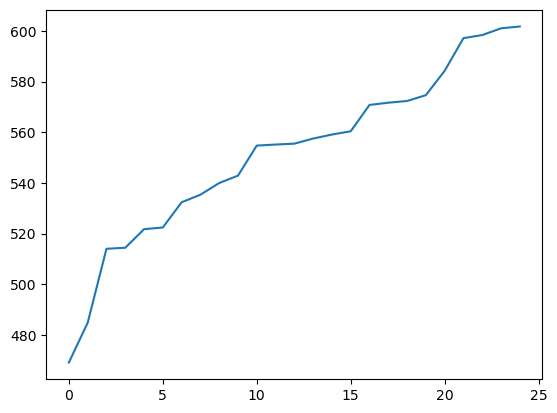

In [13]:
plt.plot(np.arange(len(scores)), scores)

In [14]:
output_dir = "./output"
save_text(best_text, best_score, target_id, output_dir=output_dir)